---
title: "Making some maps with Python"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
description: "An overview of several geospatial techniques and some of my favorite GIS packages in python."
date: "2025-7-20"
image: thumbnail.png
draft: true
categories: ['Python', 'GIS']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
---

In [286]:
#| code-fold: true
#| code-summary: "Import Statements"
import pandas as pd
import numpy as np
# Dataviz
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
from adjustText import adjust_text
# Geopatial
import geopandas as gpd
from shapely.geometry import box
import contextily as cx
import pygris.utils
import pygris
import osmnx as ox
# IO
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

One of my favorite applications of python is geospatial analysis. Something about making maps, doing spatial joins, calculating distance, etc. feels a little more satisfying than non-spatial analysis. Python happens to have an amazing collection of GIS libraries that seem capable of doing almost any geospatial task I can imagine, from basic plots to spatial statistics to remote sensing and more.  

I'm writing this blog post to give myself a  brief overview of how I currently use several of those libraries for basic plotting, and to share some spatial workflow functions that I find myself re-coding over and over across projects. My main goal here is that I will have somewhere to go for boilerplate code/tutorials for myself, but hopefully an external reader gets some value out of it too.

I'll cover the following:  

- **Some examples of Spatial Data**: GTFS transit data, U.S. Census shape files, and dealing with Coordinate Reference Systems across different datasets.
- **Plotting distributions across space**: I'll cover distributions across administrative boundaries and geospatial histograms.
- **Zooming in**, panning, and otherwise refining plots in `geopandas`.
- **Incorporating Geographic Features**: bringing in rail lines from `osmnx` and base maps from `contextily` to make web maps.

## Question
I'll base this post around a series of five exercises that seek to answer one overarching question:  

::: {.callout-tip title="Motivating Question"}
How does the distribution of public transit stops in California vary by geography?   

:::

In the exercises, I'll make plots that investigate this at various geographic levels and in subregions within California.

## Data

### GTFS Data from Cal ITP  
I will be using open data from CalTrans' [High Quality Transit Areas Analysis](https://github.com/cal-itp/data-analyses/blob/main/high_quality_transit_areas/README.md). While that analysis is focused on defining high quality transit areas, they make their intermediary transit-stop dataset and high quality transit-stop datasets available to the public. Thanks, CalTrans! 

The data that CalTrans are using are derived from "General Transit Feed Specification," or, GTFS data. GTFS is "a standardized data format that provides a structure for public transit agencies to describe the details of their services such as schedules, stops, fares, etc." It was initially developed for Google Maps ([more on the history here](https://en.wikipedia.org/wiki/GTFS#History)). The specific standards of GTFS are all documented at [gtfs.org](https://gtfs.org/getting-started/what-is-GTFS/).

Anyways, I'll grab the CalTrans  transit-stop data via parallel API requests (see the folded code for the details). This code should theoretically work with any ArcGIS API and can speed up the pagination through the chunks of data the API returns (they limit chunk size).

In [287]:
#| code-fold: true
#| code-summary: "Code for parallel API calls: `paginate_api`"
def fetch_gdf(url, offset, chunksize):
    params = {
        "outFields": "*",
        "where": "1=1",
        "f": "geojson",
        "resultOffset": offset,
        "resultRecordCount": chunksize,
    }
    try:
        response = requests.get(url, params=params, timeout=30)
        response.raise_for_status()
        return gpd.read_file(response.text)
    except Exception as e:
        print(f"Failed at offset {offset}: {e}")
        return gpd.GeoDataFrame()

def paginate_api(url):
    CHUNK_SIZE = 2000
    MAX_WORKERS = 10
    # Get total record count
    count_url = url + "?where=1=1&returnCountOnly=true&f=json"
    max_records = requests.get(count_url).json()["count"]
    print(f"Total records: {max_records}")
    # Download in parallel with TQDM
    offsets = list(range(0, max_records, CHUNK_SIZE))
    gdfs = []
    with ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {
            executor.submit(fetch_gdf, url, offset, CHUNK_SIZE): offset
            for offset in offsets
        }
        for future in tqdm(
            as_completed(futures), total=len(futures), desc="Downloading"
        ):
            gdf = future.result()
            gdfs.append(gdf)
    # Combine all chunks
    full_gdf = gpd.GeoDataFrame(
        pd.concat(gdfs, ignore_index=True), crs=gdfs[0].crs if gdfs else None
    )
    # Final output
    print(f"Final GeoDataFrame shape: {full_gdf.shape}")
    assert full_gdf.shape[0] == max_records
    return full_gdf

In [288]:
#| output: false
rest_api = "https://caltrans-gis.dot.ca.gov/arcgis/rest/"
all_stops = "services/CHrailroad/CA_Transit_Stops/FeatureServer/0/query"
gdf_all = paginate_api(rest_api + all_stops)

Total records: 130433


Downloading:   3%|▎         | 2/66 [00:00<00:23,  2.78it/s]

Downloading: 100%|██████████| 66/66 [00:10<00:00,  6.16it/s]


Final GeoDataFrame shape: (130433, 14)


The resulting dataset contains each public transit stop in California, with various pieces of information about that stop.

In [289]:
gdf_all[['district_name', 'agency', 'stop_id', 'n_routes',
         'stop_name', 'n_arrivals', 'geometry']].head()

,district_name,agency,stop_id,n_routes,stop_name,n_arrivals,geometry
0,04 - Bay Area / Oakland,Alameda-Contra Costa Transit District,52546,1,5th Avenue SB,110,POINT (-122.25336 37.79369)
1,04 - Bay Area / Oakland,Alameda-Contra Costa Transit District,52573,1,Madison SB,110,POINT (-122.26564 37.79951)
2,04 - Bay Area / Oakland,Alameda-Contra Costa Transit District,52579,1,Uptown Oakland SB,110,POINT (-122.26868 37.80854)
3,04 - Bay Area / Oakland,Alameda-Contra Costa Transit District,52596,1,31st Avenue,110,POINT (-122.22684 37.77807)
4,04 - Bay Area / Oakland,Alameda-Contra Costa Transit District,52601,1,Fruitvale,110,POINT (-122.22344 37.77644)


I noticed that a lot of geographic points that have a public transit stop are counted several times, perhaps to reflect different routes, modes of transit, etc. I'm really just interested in analyzing the distribution of unique physical "stops" without consideration of stop characteristics, so I just drop duplicates based on geometry to get every unique geographic point with a transit stop.

In [290]:
gdf_all = gdf_all.drop_duplicates(subset='geometry')

I always like to do quick checks on geospatial data via calls to `geopandas`'s `.explore()` method, which produces interactive plots in one line of code, no external library imports (e.g. `folium`) or javascript required.  

I'll look at the stops at San Pablo Ave. and Dwight Way in Berkeley, CA.

In [291]:
gdf_all[gdf_all['stop_name'] == 'San Pablo Av & Dwight Way'].explore(
    style_kwds=dict(fillOpacity=0.7, radius=12, color='red')
    )

Looks about how I'd expect! Now, returning to the motivating question: 
 
::: {.callout-tip title="Motivating Question"}
How does the distribution of public transit stops in California vary by geography?   

:::


We now have public transit stop data, but to answer this question we also need to be able to place those stops within "areas," defined broadly. For that, I'll go to the census' shapefile database.

### Census shapes with `tigris`/`pygris`

In my experience it's rare that Census data are **not** essential to doing geospatial analysis within the U.S. I'm making some plots of transit stops within California, and so off the bat I know that I will want the administrative boundaries of California and its counties to contextualize those stops. That means I need [shapefiles](https://en.wikipedia.org/wiki/Shapefile), which the Census maintains.   

::: {.callout-note title="Census data and Kyle Walker" collapse="true"}
The universe of Census data -- shapefiles and survey data -- is large and confusing. Thankfully, a few extremely generous organizations and individuals have undertaken the herculean task of developing open source tools and documentation to make census data easy. I've blogged elsewhere about IPUMS and Geocorr, but here I'm going to highlight some of the work of [Kyle Walker](https://walker-data.com/).  

Whenever I need a reference on aggregate Census data or mapping, I turn to ["Analyzing U.S. Census Data" by Kyle Walker](https://walker-data.com/census-r/). The book and accompanying geospatial libraries are written for R users, but almost all of it applies directly in python, and the author has created python ports or else blog posts with python code that cover much of the material. In practice his libraries are so good that when there isn't a direct python port for one of his R packages (e.g. tidycensus), I take the trouble of using R just for that package.  
:::  

Census shapefiles are maintained in the Census' [TIGER/Line geodatabase](https://www.census.gov/geographies/mapping-files/time-series/geo/tiger-geodatabase-file.html), which contains the shapes of basically any administrative or political boundary you could think of within the U.S. One can download files via the census' [FTP archive](https://www2.census.gov/geo/tiger/) (I've unfortunately [written a fair amount of code](https://github.com/peter-amerkhanian/sf-schools-simulation/blob/main/build_city.py) to do this in the past), but it's so much easier to just use the excellent [`tigris`](https://github.com/walkerke/tigris)/[`pygris`](https://walker-data.com/pygris/) package that Kyle Walker developed for simplifying access to TIGER/Line shapefiles. Check out the Walker text's [chapter on TIGER/Line data here](https://walker-data.com/census-r/census-geographic-data-and-applications-in-r.html).

Using `tigris`/`pygris` is very simple -- I just call the `states()` function for a given year, and it will return the outlines of every state in the U.S. as set in 2024 (note that the boundaries typically do not change for states, but they do change for some smaller geographies). I set `cache=True` and when I run the code `pygris` will automatically write out to a folder, `cache`, so that I don't need to repeat API calls.

In [292]:
state_shapes = pygris.states(cache=True, year=2024)
state_shapes.head(2)

,STATEFP,STATENS,GEOIDFQ,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,35,00897535,0400000US35,35,NM,New Mexico,00,314198519809,726531289,"POLYGON ((-109.05017 31.48, -109.04984 31.4995..."
1,46,01785534,0400000US46,46,SD,South Dakota,00,196341670967,3387563375,"POLYGON ((-104.05788 44.9976, -104.05078 44.99..."


Here's just California:

In [293]:
california = state_shapes[state_shapes["GEOID"] == "06"]
california = california.set_index("NAME")
california

,STATEFP,STATENS,GEOIDFQ,GEOID,STUSPS,LSAD,ALAND,AWATER,geometry
NAME,,,,,,,,,
California,06,01779778,0400000US06,06,CA,00,403673433805,20291632828,"MULTIPOLYGON (((-118.60442 33.47855, -118.5987..."


Here I'll do the same with `counties()`, retrieving the boundaries for all of the counties within California (`state="06"`) in 2024.

In [294]:
county_shapes = pygris.counties(state="06", year='2024', cache=True)
county_shapes[['NAMELSAD', 'geometry']].head()

,NAMELSAD,geometry
8,Sierra County,"POLYGON ((-120.55587 39.50874, -120.55614 39.5..."
324,Sacramento County,"POLYGON ((-121.43991 38.25553, -121.44002 38.2..."
328,Santa Barbara County,"MULTIPOLYGON (((-120.58226 34.10752, -120.5790..."
345,Calaveras County,"POLYGON ((-120.6318 38.34603, -120.63066 38.34..."
393,Ventura County,"MULTIPOLYGON (((-119.63607 33.28071, -119.6348..."


When we plot them together, it looks like we have the administrative boundaries we wanted.

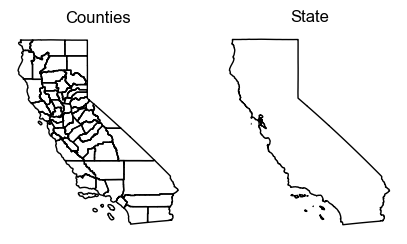

In [295]:
#| code-fold: true
#| code-summary: "Plot Code: Counties and States from `pygris`"
fig, ax = plt.subplots(1, 2, figsize=(5, 3))
ax[0].set(title="Counties")
ax[0].set_axis_off()
ax[1].set(title="State")
ax[1].set_axis_off()
county_shapes.plot(facecolor="none", ax=ax[0])
california.plot(facecolor="none", ax=ax[1]);

### Dealing with Coordinate Reference Systems

When thinking about spatial data, it may occur to you that we face a bit of a Fundamental Problem. The world is 3 dimensional and relatively spherical, whereas maps are 2 dimensional and flat. Thus, maps are abstract representations of reality. They project the 3 dimensional world into 2 dimensions with *reasonable accuracy*, but they inevitably lose some degree of accuracy in the process (see [accuracy of map projections](https://docs.qgis.org/3.40/en/docs/gentle_gis_introduction/coordinate_reference_systems.html#accuracy-of-map-projections)). Cartographers have developed a whole world of different 3D -> 2D **map projections**, typically designed with specific uses and geographies (e.g. distance calculation in north america) in mind, which makes choosing the right projection important...

![Examples of a Geographic Coordinate System (GCS) and a Projected Coordinate System (PCS) [from ESRI.](https://www.esri.com/arcgis-blog/products/arcgis-pro/mapping/gcs_vs_pcs)](grid2.png){width=80%}

When we talk about different map projections, we describe them in terms of their coordinate reference system (CRS), which defines, with the help of coordinates, how the two-dimensional, projected map is related to real locations on the earth. For reference, here are all of the CRS that I will use in this post:

| Purpose          | CRS Name                | EPSG | Type       | Units   | Region   | Organizations / Notes                                                             |
| ---------------- | -------------------------- | ---- | ---------- | ------- | ----------------- | --------------------------------------------------------------------------------- |
| Plotting         | [WGS 84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84)                     | 4326 | Geographic | Degrees | Global            | Used globally for web and GPS data, published and maintained by the U.S. Department of Defense.                  |                                     |
| Plotting | [NAD83](https://en.wikipedia.org/wiki/North_American_Datum#)                      | 4269 | Geographic | Degrees | North America     | US Census Bureau, USGS; preferred for U.S. datasets                               |
| Web Mapping      | [WGS 84 / Pseudo-Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection#)   | 3857 | Projected  | Meters  | Global | Default for web maps (Leaflet, Mapbox); **distorts area and distance -- exercise caution!**                |
| Spatial Analysis | NAD83 / California Albers  | 3310 | Projected  | Meters  | California        | CA state agencies, minimizes distortion across the state                          |


In [382]:
NAD_CRS = "EPSG:4269"
CA_ALBERS_CRS = "EPSG:3310"
PSEUDO_MERCATOR_CRS = "EPSG:3857"

The public transit stop data from the CalTrans come in a common and versatile CRS, [World Geodetic System (WGS) 84](https://en.wikipedia.org/wiki/World_Geodetic_System#WGS84), also known as [`EPSG:4326`](https://epsg.io/4326?utm_source=chatgpt.com). Many global or multi-national datasets use **WGS 84**, including the Google Earth service. WGS84 is "geodetic," meaning that distance is measured in longitudinal/latitudinal degrees.

In [296]:
gdf_all.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

U.S. Census TIGER/Line data typically use [North American Datum (NAD) 83](https://en.wikipedia.org/wiki/North_American_Datum), EPSG code [`4269`](https://epsg.io/4269). **NAD83** is commonly used by U.S. Federal Agencies and, like WGS84, it is "geodetic" and measures distance in degrees. Unlike WGS84, NAD83 is optimized for geographic accuracy within the United States.

In [297]:
assert california.crs == county_shapes.crs
california.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

When working with multiple datasets, it’s important to ensure that they share the same CRS. In GeoPandas, CRS alignment and conversion are straightforward. I'd like to work in the CRS provided by the U.S. Census -- NAD83. I use simple variable assignment in python to bring the stops dataset (currently in WGS84) into NAD83.

In [298]:
target_crs = california.crs
gdf_all.crs = target_crs

In [299]:
assert gdf_all.crs == california.crs
print(gdf_all.crs, "==", california.crs)

EPSG:4269 == EPSG:4269


Now that I have both the California shapefile and the public transit stops in the same CRS, I can start to use them together. First, I'll do a spatial join -- I'll filter the public transit stops down to only those that are within the California shapefile.

In [300]:
gdf_ca = gdf_all.copy().sjoin(california, how="inner", predicate="within")

I'll plot the resulting raw stop data over the California shapefile.

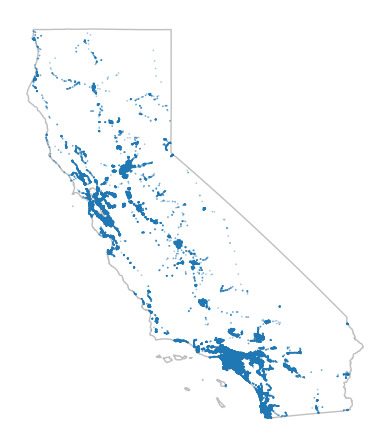

In [301]:
fig, ax = plt.subplots(figsize=(4, 5))
assert california.crs == gdf_ca.crs
california.plot(ax=ax, edgecolor="grey", facecolor="none",
                linewidth=1, zorder=-1, alpha=.5)
gdf_ca.plot(ax=ax, markersize=1.5, alpha=0.4, edgecolor="none", linewidth=0.05)
ax.axis("off")
fig.tight_layout()

Looks good, but how does it do for answering our motivating question?  

::: {.callout-tip title="Motivating Question"}
How does the distribution of public transit stops in California vary by geography?   

:::

One can pick out the basic pattern that urban California has a lot of transit stops and rural California doesn't, but I'd like to go deeper and explore how aggregating stops into larger geographies helps pick out different trends.

## Exercise 1: County Choropleth

One very common geospatial data product is the [choropleth](https://en.wikipedia.org/wiki/Choropleth_map) map. Choropleth maps communicate how the density of some data or else another quantity that describes that data varies across administrative units, like countries, states, provinces, etc. The data are grouped into the administrative units, and the aggregate value for each unit is depicted in the map via color intensity/hue/saturation.  

![[Wikipedia says](https://en.wikipedia.org/wiki/Choropleth_map#History) this 1826 choropleth depicting the availability of basic education in France is the earliest known choropleth map](choropleth.jpg){width=50%}

In [302]:
#| code-fold: true
#| code-summary: "Some custom plotting code/functions: `build_cmap`, `number_suffix_formatter`"

plt.rcParams["font.family"] = "Arial"

def build_cmap(
    mpl_name: str = "coolwarm",
    start: float = 0.0,
    end: float = 1.0,
    int_gran: int = 1000,
) -> LinearSegmentedColormap:
    """
    Create a customized linear colormap by truncating an existing Matplotlib colormap.

    Parameters
    ----------
    mpl_name : str, default="coolwarm"
        The name of a Matplotlib colormap. See the full list at:
        https://matplotlib.org/stable/gallery/color/colormap_reference.html

    start : float, default=0
        The starting position in the original colormap's range [0, 1].

    int_gran : int, default=1000
        The number of discrete color samples to generate from the truncated colormap.
        Higher values yield smoother gradients.

    Returns
    -------
    LinearSegmentedColormap
        A new colormap instance truncated from the original, beginning at `start`.

    Raises
    ------
    AssertionError
        If `start` is not between 0 and 1 (inclusive).

    Examples
    --------
    >>> cmap = build_cmap("viridis", start=0.2)
    >>> plt.imshow(data, cmap=cmap)
    """
    assert (start <= 1) & (start >= 0), "start must be real number in [0, 1]"
    cmap = mpl.colormaps.get_cmap(mpl_name)
    new_cmap = LinearSegmentedColormap.from_list(
        "deep_reds", cmap(np.linspace(start, end, int_gran))
    )
    return new_cmap

def number_suffix_formatter(x, pos=None):
    """
    Formats numbers using k (thousand) and m (million) suffixes.
    
    Parameters:
        x (float or int): Number to format.
        pos: Ignored, included for compatibility with matplotlib's FuncFormatter.

    Returns:
        str: Formatted string.
    """
    thresholds = [
        (1e9, 'b'),
        (1e6, 'm'),
        (1e3, 'k'),
    ]
    for threshold, suffix in thresholds:
        if x >= threshold:
            value = x / threshold
            return f"{value:.1f}{suffix}" if x % threshold else f"{int(value)}{suffix}"
    return str(int(x))

We want to make a choropleth of our transit stops dataset across counties, and the first step is going to be aggregating those stops (`Point` data) within counties (`Polygon` data). Here's an abstract representation of the problem -- we want to count the "Inside Points":

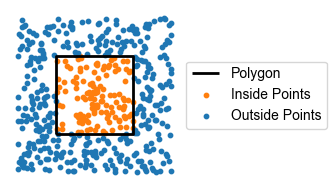

In [359]:
#| echo: false
#| fig-cap: "Points within a Polygon"
from shapely.geometry import Point, Polygon
from util import custom_legend

polygon = Polygon([(0, 0), (0, 10), (10, 10), (10, 0)])
gdf_polygon = gpd.GeoDataFrame(index=[0], geometry=[polygon], crs="EPSG:4326")

num_points = 500
x_coords = np.random.uniform(-5, 15, num_points)
y_coords = np.random.uniform(-5, 15, num_points)
points = [Point(x, y) for x, y in zip(x_coords, y_coords)]
gdf_points = gpd.GeoDataFrame(geometry=points, crs="EPSG:4326")

gdf_points["inside"] = gdf_points.within(polygon)
fig, ax = plt.subplots(figsize=(6, 2))
gdf_polygon.boundary.plot(ax=ax, color='black', linewidth=2, label='Polygon')
gdf_points[gdf_points["inside"]].plot(ax=ax, color='tab:orange', label='Inside Points', markersize=10)
gdf_points[~gdf_points["inside"]].plot(ax=ax, color='tab:blue', label='Outside Points', markersize=10)

ax.set_axis_off()
custom_legend(ax, outside_loc="center")
fig.tight_layout();


Here's my custom `points_in_polygon()` function that will count up the number of points from one gdf, `point_gdf` that are within the shape from another gdf, `polygon_gdf`. There's an optional weight variable that I won't be using.

In [304]:
def points_in_polygon(
    point_gdf: gpd.GeoDataFrame,
    polygon_gdf: gpd.GeoDataFrame,
    group_var: str,
    weight_var: str = None,
) -> gpd.GeoDataFrame:
    assert point_gdf.crs == polygon_gdf.crs, f"{point_gdf.crs} != {polygon_gdf.crs}"
    joined = point_gdf.sjoin(polygon_gdf, how="inner", predicate="within")
    if weight_var:
        agg = joined.groupby(group_var)[weight_var].sum().to_frame(f"{weight_var}_sum")
        result = polygon_gdf.copy()
        result = result.merge(agg, left_on=group_var, right_index=True, how="left")
    else:
        counts = joined.groupby(group_var).size().to_frame("count")
        result = polygon_gdf.copy()
        result = result.merge(counts, left_on=group_var, right_index=True, how="left")
    return result

You can see that the logic is based on spatially merging the points with the polygons based on whether points fall "within" polygons, then I group by the polygon identifier and count up how many points there are within each. When we run that with the transit stops and counties, we get the following.

In [305]:
county_agg = points_in_polygon(gdf_all, county_shapes, group_var="NAME")
county_agg[['NAME', 'count']].head()

,NAME,count
8,Sierra,NaN
324,Sacramento,3367.0
328,Santa Barbara,1069.0
345,Calaveras,19.0
393,Ventura,1295.0


With that aggregated data, I can now make a choropleth of transit stops across counties. I'll start with defining various stylings for the map (code is folded as it's less relevant). I often like to define parameters for `geopandas` plots in dictionaries so that I can reuse styles across different plots.

In [306]:
#| code-fold: true
#| code-summary: "Plot Styling: `new_cmap`, `missing_fill_kws`, `borders_kws`,  `data_fill_kws`"
# Legend
new_cmap = build_cmap("YlOrRd", start=0, end=1)
legend_cbar_kws = {
    "format": FuncFormatter(number_suffix_formatter),
    "shrink": 0.8,
    "label": "Number of Public Transit Stops",
    "location": "top",
    "pad": 0.01,
}
# General County Style
borders_kws = {"edgecolor": "grey", "linewidth": 0.3}
data_fill_kws = {"alpha": 1, "cmap": new_cmap}
# Missing County Style
missing_fill_kws = {"hatch": "////", "facecolor": "none"}
missing_patch = Patch(**borders_kws, **missing_fill_kws, label="County w/ no stops")

You can pass the dictionaries directly into the plotting functions as unpacked variables, which you can see below with `**missing_fill_kws`, `**borders_kws`, and `**data_fill_kws`.

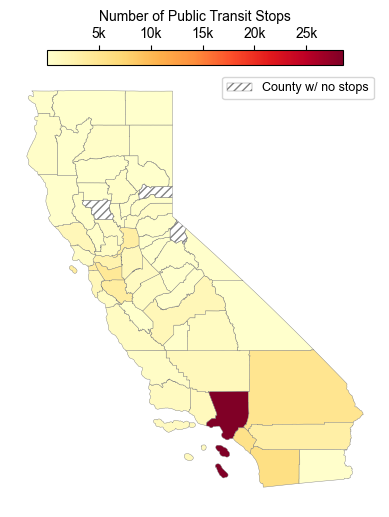

In [307]:
fig, ax = plt.subplots(figsize=(4, 6))
county_agg = points_in_polygon(gdf_all, county_shapes, group_var="NAME")
county_agg.plot(
    column="count",
    **borders_kws,
    **data_fill_kws,
    ax=ax,
    legend=True,
    legend_kwds=legend_cbar_kws,
)
county_agg[county_agg["count"].isna()].plot(**missing_fill_kws, **borders_kws, ax=ax)
ax.legend(handles=[missing_patch], fontsize=9)
ax.axis("off")
fig.tight_layout()

## Exercise 2: Region Choropleth

To provide additional perspective, we're going to make another choropleth using a different geographic unit. I'd like to get a look at how stop availability differs across larger regions, such as the San Francisco Bay Area, Los Angeles, the Central Valley, etc. I don't have a regions dataset, but I do have a counties dataset and regions are typically made up of counties, so this will be an opportunity to try combining smaller geographies into larger, custom geographies.  

In the following folded code chunk I'll define a mapping of counties to regions based on [a mapping the state adopted during the 2020 Census](https://census.ca.gov/regions/):

In [308]:
#| code-fold: true
#| code-summary: "California County → Region Mappings, `county_to_region`"
# https://census.ca.gov/regions/
county_to_region = {
    "Butte": "Superior California",
    "Colusa": "Superior California",
    "El Dorado": "Superior California",
    "Glenn": "Superior California",
    "Lassen": "Superior California",
    "Modoc": "Superior California",
    "Nevada": "Superior California",
    "Placer": "Superior California",
    "Plumas": "Superior California",
    "Sacramento": "Superior California",
    "Shasta": "Superior California",
    "Sierra": "Superior California",
    "Siskiyou": "Superior California",
    "Sutter": "Superior California",
    "Tehama": "Superior California",
    "Yolo": "Superior California",
    "Yuba": "Superior California",
    "Del Norte": "North Coast",
    "Humboldt": "North Coast",
    "Lake": "North Coast",
    "Mendocino": "North Coast",
    "Napa": "North Coast",
    "Sonoma": "North Coast",
    "Trinity": "North Coast",
    "Alameda": "San Francisco Bay Area",
    "Contra Costa": "San Francisco Bay Area",
    "Marin": "San Francisco Bay Area",
    "San Francisco": "San Francisco Bay Area",
    "San Mateo": "San Francisco Bay Area",
    "Santa Clara": "San Francisco Bay Area",
    "Solano": "San Francisco Bay Area",
    "Alpine": "Northern San Joaquin Valley",
    "Amador": "Northern San Joaquin Valley",
    "Calaveras": "Northern San Joaquin Valley",
    "Madera": "Northern San Joaquin Valley",
    "Mariposa": "Northern San Joaquin Valley",
    "Merced": "Northern San Joaquin Valley",
    "Mono": "Northern San Joaquin Valley",
    "San Joaquin": "Northern San Joaquin Valley",
    "Stanislaus": "Northern San Joaquin Valley",
    "Tuolumne": "Northern San Joaquin Valley",
    "Monterey": "Central Coast",
    "San Benito": "Central Coast",
    "San Luis Obispo": "Central Coast",
    "Santa Barbara": "Central Coast",
    "Santa Cruz": "Central Coast",
    "Ventura": "Central Coast",
    "Fresno": "Southern San Joaquin Valley",
    "Inyo": "Southern San Joaquin Valley",
    "Kern": "Southern San Joaquin Valley",
    "Kings": "Southern San Joaquin Valley",
    "Tulare": "Southern San Joaquin Valley",
    "Riverside": "Inland Empire",
    "San Bernardino": "Inland Empire",
    "Los Angeles": "Los Angeles",
    "Orange": "Orange County",
    "Imperial": "San Diego-Imperial",
    "San Diego": "San Diego-Imperial",
}

Now that I have the mappings dictionary, I can map those onto the county names in my dataset:

In [365]:
county_shapes["region"] = county_shapes["NAME"].map(county_to_region)
county_shapes[["NAME", "region"]].head(4)

,NAME,region
8,Sierra,Superior California
324,Sacramento,Superior California
328,Santa Barbara,Central Coast
345,Calaveras,Northern San Joaquin Valley


Now that the mapping is established, I need to combine the county shapes up into parent region shapes. This spatial operation is called a `dissolve()` in geopandas. Here's an abstract representation of what `dissolve()` does:  


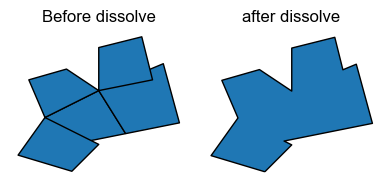

In [371]:
#| echo: false
#| fig-cap: "The effect of `dissolve()`"
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# Define more irregular polygons for Region Y
polygons = [
    Polygon([(0.5, 2), (1.5, 2.2), (1, 3), (0, 2.5)]),         # part 1
    Polygon([(1.5, 2.2), (2.5, 2.4), (2.2, 3.5), (1, 3)]),     # part 2
    Polygon([(0, 2.5), (-0.5, 1.8), (0.5, 1.5), (1, 2)]),      # part 3
    Polygon([(1, 3), (2, 3.2), (1.8, 4), (1, 3.8)]),           # part 5
    Polygon([(0, 2.5), (-0.3, 3.2), (0.4, 3.4), (1, 3)])       # part 6
]

# Create a GeoDataFrame
gdf = gpd.GeoDataFrame({
    'region': ['Y'] * len(polygons),
    'subset': range(0, len(polygons)),
    'geometry': polygons
})

# Dissolve by 'region'
dissolved = gdf.dissolve(by='region')

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(4, 2))

# Left: individual parts
gdf.plot(ax=axes[0],color='tab:blue',  edgecolor='black', linewidth=1)
axes[0].set_title("Before dissolve")
axes[0].set_axis_off()

# Right: merged shape
dissolved.plot(ax=axes[1], color='tab:blue', edgecolor='black', linewidth=1)
axes[1].set_title("after dissolve")
axes[1].set_axis_off()
plt.tight_layout()
plt.show()


Here we will create a new gdf, `regions`, with the results of dissolving the counties up into regions.

In [310]:
regions = county_shapes.dissolve(by="region")
assert county_shapes.crs == regions.crs

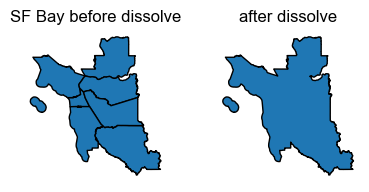

In [358]:
#| echo: false
#| fig-cap: "Dissolving the Bay Area counties"
fig, axes = plt.subplots(1, 2, figsize=(4, 2))
region = "San Francisco Bay Area"
county_shapes.query(f'region == "{region}"').plot(ax=axes[0],color='tab:blue',  edgecolor='black', linewidth=1)
axes[0].set_title("SF Bay before dissolve")
axes[0].set_axis_off()
regions.loc[[region], :].plot(ax=axes[1], color='tab:blue', edgecolor='black', linewidth=1)
axes[1].set_title("after dissolve")
axes[1].set_axis_off()
plt.tight_layout()
plt.show()


In [313]:
def split_name_middle(name):
    parts = name.replace("-", " ").split()
    if len(parts) <= 1:
        return name  # nothing to split
    mid = len(parts) // 2
    # Insert newline at the midpoint between words
    return " ".join(parts[:mid]) + "\n" + " ".join(parts[mid:])

def label_polygon(
    gdf: gpd.GeoDataFrame,
    ax,
    column: str,
    adjust_list: list = [],
    adjust_kws={},
    text_kws={},
):
    texts = []
    for _, row in gdf.iterrows():
        if row["geometry"].is_empty or row["geometry"].centroid.is_empty:
            continue
        point = row["geometry"].centroid
        x, y = point.x, point.y
        if row[column] in adjust_list:
            texts.append(ax.text(x, y, split_name_middle(row[column]), **text_kws))
        else:
            ax.text(x, y, split_name_middle(row[column]), **text_kws)
    adjust_text(texts, ax=ax, **adjust_kws)

In [314]:
#| code-fold: true
#| code-summary: "Plot Styling"
new_cmap = build_cmap("coolwarm_r", start=0.1, end=0.9)
borders_kws = {"edgecolor": "grey", "linewidth": 0.3}
data_fill_kws = {"alpha": 0.7, "cmap": new_cmap}
missing_fill_kws = {"hatch": "////", "facecolor": "none"}
legend_cbar_kws = {
    "format": FuncFormatter(number_suffix_formatter),
    "shrink": 0.7,
    "label": "Number of Public Transit Stops",
    "location": "top",
    "pad": 0.001,
}
adjust_kws = {
    "avoid_self": True,
    "expand": (7, 3),
    "arrowprops": {
        "arrowstyle": "-",
        "color": "black",
        "lw": 1,
        "connectionstyle": "arc3,rad=0.1",
    },
}
text_kws = {
    "fontsize": 8,
    "ha": "center",
    "va": "center",
    "color": "black",
}

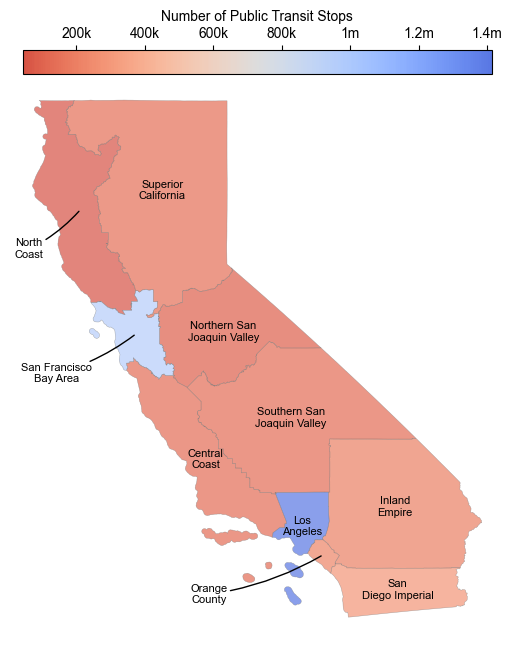

In [315]:
fig, ax = plt.subplots(figsize=(7, 7))
arrivals_in_regions = points_in_polygon(
    gdf_all,
    regions.reset_index(),
    group_var="region",
    weight_var="n_arrivals",
)
arrivals_in_regions.plot(
    column="n_arrivals_sum",
    ax=ax,
    **data_fill_kws,
    **borders_kws,
    legend=True,
    legend_kwds=legend_cbar_kws
)
label_polygon(
    arrivals_in_regions,
    ax,
    "region",
    adjust_list=["San Francisco Bay Area", "Orange County", "North Coast"],
    adjust_kws=adjust_kws,
    text_kws=text_kws,
)
ax.axis("off")
fig.tight_layout()

## Exercise 3: Heatmaps

> [...] heat maps may also visualize data over a geographic region. However, unlike choropleth maps, heat maps show the proportion of a variable over an arbitrary, but usually small grid size, independent of geographic boundaries.  

https://en.wikipedia.org/wiki/Heat_map#Choropleth_maps_versus_heat_maps

https://en.wikipedia.org/wiki/Ecological_fallacy

This code is complex, but it's based around one function, `np.histogram2d`, which takes in point data and aggregates it into bins.

In [316]:
#| code-fold: true
#| code-summary: "Geospatial Histogram Functions: `histogram_to_geodataframe` and `geospatial_histogram`"

def histogram_to_geodataframe(hist, x_edges, y_edges, crs=None):
    """
    Convert a 2D histogram and bin edges into a GeoDataFrame of grid cells with counts.

    Parameters:
    ----------
    hist : 2D numpy array
        The histogram values (as returned by geospatial_histogram, already transposed).
    x_edges : 1D numpy array
        Bin edges along the x-axis.
    y_edges : 1D numpy array
        Bin edges along the y-axis.
    crs : any (optional)
        Coordinate reference system for the GeoDataFrame.

    Returns:
    -------
    gdf : GeoDataFrame
        A GeoDataFrame with one polygon per grid cell, with a 'count' column.
    """
    rows, cols = hist.shape
    polygons = []
    counts = []

    for i in range(rows):
        for j in range(cols):
            count = hist[i, j]
            if count == 0:
                continue  # Skip empty cells for efficiency
            x0 = x_edges[j]
            x1 = x_edges[j + 1]
            y0 = y_edges[i]
            y1 = y_edges[i + 1]
            polygons.append(box(x0, y0, x1, y1))
            counts.append(count)

    gdf = gpd.GeoDataFrame({"count": counts, "geometry": polygons}, crs=crs)
    return gdf


def geospatial_histogram(gdf, cell_size, bounds=None, weights=None):
    """
    Create a 2D geospatial histogram (raster grid of counts) from a GeoDataFrame of points.

    Parameters:
    ----------
    gdf : GeoDataFrame
        Must contain Point geometries in a projected CRS (e.g. meters).
    cell_size : float
        Width and height of grid cells (in CRS units, e.g. meters).
    bounds : tuple or None
        Optional (minx, miny, maxx, maxy). If None, computed from gdf.bounds.

    Returns:
    -------
    hist : 2D numpy array
        Histogram counts of points per grid cell.
    (Optional) x_edges, y_edges : 1D numpy arrays
        Bin edges in x and y directions.
    """
    assert gdf.crs.is_projected, "CRS must be projected first, e.g. `gdf.set_crs()`"
    if gdf.empty:
        raise ValueError("Input GeoDataFrame is empty.")
    if not gdf.geometry.geom_type.isin(["Point"]).all():
        raise ValueError("All geometries must be Points.")

    x = gdf.geometry.x.values
    y = gdf.geometry.y.values

    if weights is not None:
        weights = np.asarray(gdf[weights])
        if len(weights) != len(gdf):
            raise ValueError("Length of weights must match number of points in gdf.")

    if bounds is None:
        minx, miny, maxx, maxy = gdf.total_bounds
    else:
        minx, miny, maxx, maxy = bounds
    # Define bin edges
    x_bins = np.arange(minx, maxx + cell_size, cell_size)
    y_bins = np.arange(miny, maxy + cell_size, cell_size)
    # Compute histogram
    hist, x_edges, y_edges = np.histogram2d(
        x, y, bins=[x_bins, y_bins], weights=weights
    )
    # histogram2d returns shape (len(x_bins)-1, len(y_bins)-1) with axes (x, y)
    # Transpose so that rows = y, columns = x (like image/raster orientation)
    hist = hist.T
    return histogram_to_geodataframe(hist, x_edges, y_edges, crs=gdf.crs)

In [317]:
#| code-fold: true
#| code-summary: "Plot Styling: `legend_cbar_kws`, `square_patch`, `borders_kws`"
new_cmap = build_cmap("YlOrRd", start=0, end=1)
legend_cbar_kws = {
    "format": FuncFormatter(number_suffix_formatter),
    "shrink": 0.8,
    "label": "Number of Public Transit Stops",
    "location": "top",
    "pad": 0.001,
}
data_fill_kws = {"alpha": 1, "cmap": new_cmap}
square_patch = mpatches.Rectangle(
    (0, 0), 10, 10, facecolor=new_cmap.get_under(), edgecolor="grey", linewidth=0.8
)
borders_kws = {"edgecolor": "grey", "linewidth": 0.1}

In [318]:
cell_size = 20_000
gdf_ca_proj = gdf_ca.to_crs(CA_ALBERS_CRS)
california_proj = california.to_crs(CA_ALBERS_CRS)
assert gdf_ca_proj.crs == california_proj.crs
arrivals_hist = geospatial_histogram(
    gdf_ca_proj, weights=None, cell_size=cell_size
)
assert arrivals_hist.crs == california_proj.crs

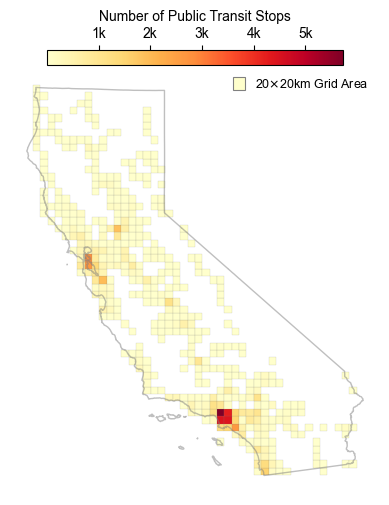

In [319]:
fig, ax = plt.subplots(figsize=(4, 6))
california_proj.plot(
    ax=ax, edgecolor="grey", facecolor="none", linewidth=1, alpha=0.5
)
arrivals_hist.plot(
    column="count",
    ax=ax,
    **data_fill_kws,
    **borders_kws,
    zorder=-1,
    legend=True,
    legend_kwds=legend_cbar_kws,
)
ax.legend(
    handles=[square_patch],
    labels=[rf"{int(cell_size/1000)}$\times${int(cell_size/1000)}km Grid Area"],
    loc="upper right",
    frameon=False,
    fontsize=9,
    handlelength=1.0,
    handleheight=1.25,
)
ax.axis("off")
fig.tight_layout()

## Exercise 4: Refining Land

In [320]:
#| output: false
hq_stops = "services/CHrailroad/CA_HQ_Transit_Stops/FeatureServer/0/query"
gdf_hq = paginate_api(rest_api + hq_stops)

Total records: 66412


Downloading: 100%|██████████| 34/34 [00:06<00:00,  5.03it/s]

Final GeoDataFrame shape: (66412, 15)


In [321]:
gdf_hq = gdf_hq[~gdf_hq['hqta_details'].str.contains('planned')]
gdf_hq = gdf_hq[gdf_hq['hqta_type'].str.contains('major_stop')]
gdf_hq = gdf_hq.drop_duplicates(subset='geometry')

In [322]:
gdf_hq[['hqta_type', 'stop_id', 'hqta_details','avg_trips_per_peak_hr', 'geometry']].head()

,hqta_type,stop_id,hqta_details,avg_trips_per_peak_hr,geometry
3444,major_stop_brt,13124,major_stop_brt_single_operator,5,POINT (-122.39933 37.7842)
3451,major_stop_brt,13136,major_stop_brt_single_operator,5,POINT (-122.40211 37.78637)
3458,major_stop_brt,13144,major_stop_brt_single_operator,5,POINT (-122.3962 37.78165)
3464,major_stop_brt,13191,major_stop_brt_single_operator,4,POINT (-122.40337 37.77327)
3465,major_stop_brt,13192,major_stop_brt_single_operator,3,POINT (-122.4079 37.77686)


In [323]:
gdf_hq.crs = regions.crs

In [324]:
print("Total Public Transit Stops:", gdf_all.shape[0])
print("High Quality Public Transit Stops:", gdf_hq.shape[0])

Total Public Transit Stops: 89239
High Quality Public Transit Stops: 10396


In [325]:
assert gdf_hq.crs == regions.crs
gdf_bay_hq = gdf_hq.copy()[gdf_hq.geometry.within(regions.loc["San Francisco Bay Area"].geometry)]
sf_bay_county_shapes = county_shapes.copy()[county_shapes["region"] == "San Francisco Bay Area"]

One issue with making a plot of the San Francisco Bay Area is that the [Farallon Islands](https://en.wikipedia.org/wiki/Farallon_Islands#Geography) are technically part of the administrative boundaries of San Francisco county (indeed, they, along with The Sunset Neighborhood, are a part of the political boundaries of Supervisorial District 4!). You can see the islands on the far left in the following plot of the Bay Area counties.

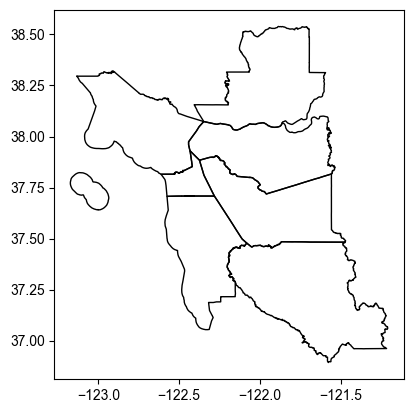

In [326]:
sf_bay_county_shapes.plot(facecolor="none");

Including the islands in an analysis focused on the human population of the Bay Area and the availability of public transit doesn't seem appropriate, so we want to find a data-driven way to remove that land mass.  

![Here's a picture of the [Farallon Islands](https://commons.wikimedia.org/wiki/File:SE_Farallon_Island.jpg
) -- I don't see public transit stops.](View_from_Mirounga_Bay.jpg){width=50%}


The answer starts with an "explosion" -- we can use the [`.explode()` method](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.explode.html) from `geopandas` to break any multi-part geometries (in this case the multi-part polygon of San Francisco County with some pieces that are non-contiguous) into individual geometries.

In [327]:
exploded_shapes = (
    sf_bay_county_shapes
    .explode(index_parts=True, ignore_index=True)
    .reset_index(names='shape_index')
)
# Check retention of crs
assert sf_bay_county_shapes.crs == exploded_shapes.crs
print("Pre-explosion shape", sf_bay_county_shapes.shape)
print("Post-explosion shape", exploded_shapes.shape)

Pre-explosion shape (7, 20)
Post-explosion shape (8, 21)


We can see that, following the explosion, our dataframe has one new geometry -- the Farallon Islands. Now we will bring back our `points_in_polygon` function so that we can count how many high quality public transit stops are in each of the geometries.

In [328]:
exploded_shapes = points_in_polygon(gdf_bay_hq, exploded_shapes, "shape_index")
assert exploded_shapes.crs == sf_bay_county_shapes.crs

We can see that one of these doesn't have any stops. It's still called "San Francisco," but this is the Farallon Islands geometry, which, since they are unpopulated islands, doesn't contain any transit stops.

In [329]:
exploded_shapes[['NAME', 'count']].head(3)

,NAME,count
0,San Francisco,1600.0
1,San Francisco,NaN
2,Marin,44.0


We'll use that as a filtering condition to remove the islands from the dataset, and we arrive at a clean dataset of the populated geometries of the Bay Area counties.

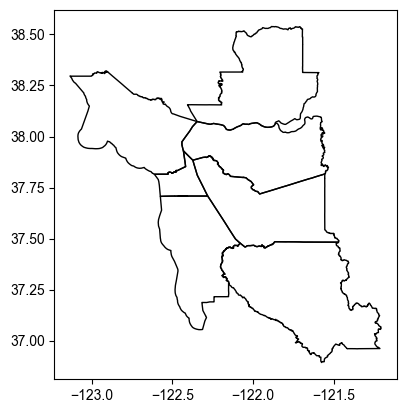

In [330]:
sf_bay_county_shapes = exploded_shapes[exploded_shapes['count'] > 0]
sf_bay_county_shapes.plot(facecolor="none");

Let's continue refining this. The San Francisco Bay Area is known for being a bay, as in, there is a large body of water at the center of it. This map doesn't reflect that yet and that's problematic for plotting the distribution of transit stops in the area. We may see large swaths of map with no stops and assume that it's a transit desert, when in fact it's just a body of water.  

![It would be useful to convey how much water there is in [the Bay Area](https://commons.wikimedia.org/wiki/File:San_Francisco_and_SFO_Aerial_2018.jpg)](bay_panorama.jpg){width=50%}

The bodies of water that make up the bay are all part of administrative boundaries of counties, so to include the bay, we will need to break out the geometries for water within each county. This sounds hard, and again, in the past I have [written custom code to accomplish this](https://github.com/peter-amerkhanian/sf-schools-simulation/blob/b8b956180289e079bef43d15808066eb01f2fa6c/build_city.py#L50C1-L59C29), but it's now incredibly easy using the `tigris`/`pygris` package and its useful `erase_water()` function.

In [331]:
bay_area_no_water = pygris.utils.erase_water(
    sf_bay_county_shapes,
    year=2024,
    cache=True
)
assert bay_area_no_water.crs == sf_bay_county_shapes.crs

HTTP download failed, trying FTP as fallback...


After using the census' 2024 water boundaries to remove water from the county shapes, we arrive at the following map.

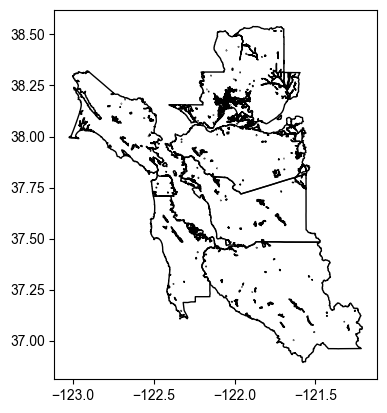

In [332]:
bay_area_no_water.plot(facecolor="none");

Now that looks like the Bay Area!

In [333]:
#| echo: false
#| output: false

# # Dataset
# cell_size = 5_000
# gdf_bay_proj= gdf_bay_hq.to_crs("EPSG:3310")
# bay_area_no_water_proj= bay_area_no_water.to_crs("EPSG:3310")
# assert gdf_bay_proj.crs == bay_area_no_water_proj.crs
# bay_arrivals_hist = geospatial_histogram(
#     gdf_bay_proj, weights=None, cell_size=cell_size
# )
# assert bay_arrivals_hist.crs == bay_area_no_water_proj.crs

# # Style
# legend_cbar_kws = {
#     "format": FuncFormatter(number_suffix_formatter),
#     "shrink": 0.8,
#     "label": "Number of High Quality Public Transit Stops",
#     "location": "top",
#     "pad": 0.001,
# }
# new_cmap = build_cmap("YlOrRd", 0.1)
# borders_kws = {"edgecolor": "grey", "linewidth": 0.3}
# data_fill_kws = {"alpha": 0.7, "cmap": new_cmap}
# square_patch = mpatches.Rectangle(
#     (0, 0), 10, 10, facecolor=new_cmap.get_under(), edgecolor="grey", linewidth=0.8
# )
# #Plotting
# fig, ax = plt.subplots(figsize=(6, 6))
# bay_area_no_water_proj.plot(
#     ax=ax, edgecolor="black", facecolor="none", linewidth=1, alpha=0.3, zorder=-1
# )
# bay_arrivals_hist.plot(
#     column="count",
#     ax=ax,
#     **data_fill_kws,
#     **borders_kws,
#     vmax=500,
#     legend=True,
#     legend_kwds=legend_cbar_kws,
# )
# ax.legend(
#     handles=[square_patch],
#     labels=[rf"{int(cell_size/1000)}$\times${int(cell_size/1000)}km Grid Area"],
#     loc="upper left",
#     frameon=False,
#     fontsize=9,
#     handlelength=1.5,
#     handleheight=2,
# )
# ax.axis("off")
# fig.tight_layout()

In [334]:
# Dataset
cell_size = 5_000
gdf_bay_proj= gdf_bay_hq.to_crs(CA_ALBERS_CRS)
bay_area_no_water_proj= bay_area_no_water.to_crs(CA_ALBERS_CRS)
sf_bay_county_shapes_proj = sf_bay_county_shapes.to_crs(CA_ALBERS_CRS)
assert gdf_bay_proj.crs == bay_area_no_water_proj.crs
bay_arrivals_hist = geospatial_histogram(
    gdf_bay_proj, weights=None, cell_size=cell_size
)
assert bay_arrivals_hist.crs == bay_area_no_water_proj.crs

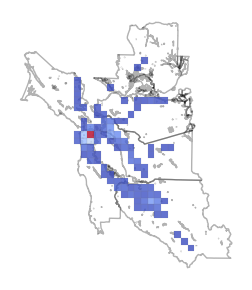

In [335]:
#| echo: false
#| output: false
fig, ax = plt.subplots(figsize=(3, 3))
bay_arrivals_hist.plot(column='count', ax=ax, cmap='coolwarm', alpha=.8,
    **borders_kws)
bay_area_no_water_proj.plot(
    ax=ax, edgecolor="black", facecolor="none", linewidth=1, alpha=0.3, zorder=-1
)
ax.axis("off")
fig.tight_layout()
fig.savefig('thumbnail.png', bbox_inches='tight', dpi=300)

In [379]:
#| code-fold: true
#| code-summary: "Plot Styling: `legend_cbar_kws`, `data_fill_kws`, `adjust_kws`, `text_kws`, `square_patch`"
legend_cbar_kws = {
    "format": FuncFormatter(number_suffix_formatter),
    "shrink": 0.8,
    "label": "Number of High Quality Public Transit Stops",
    "location": "top",
    "pad": 0.001,
}
adjust_kws = {
    "avoid_self": True,
    "expand": (7, 3),
    "arrowprops": {
        "arrowstyle": "->",
        "color": "black",
        "lw": 1,
        "connectionstyle": "arc3,rad=0.01",
    },
}
data_fill_kws = {"alpha": .75, "cmap": new_cmap}
text_kws = {"fontsize": 9, "ha": "center", "va": "center", "color": "black"}
square_patch = mpatches.Rectangle(
    (0, 0), 10, 10, facecolor=new_cmap.get_under(), edgecolor="grey", linewidth=0.8
)

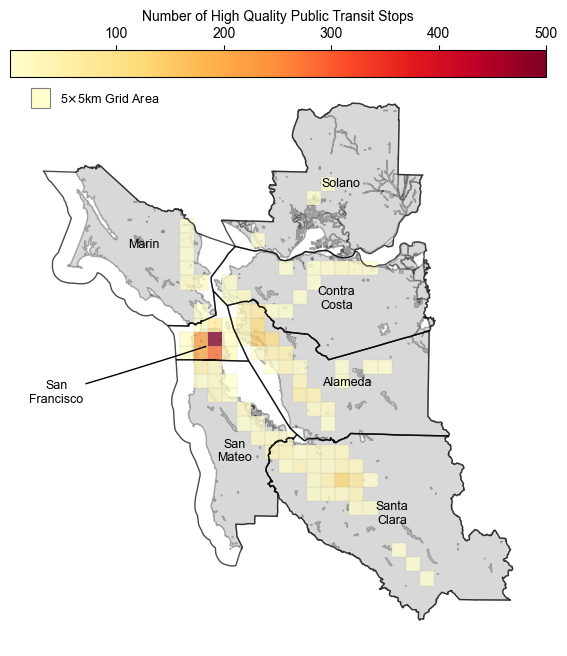

In [380]:

fig, ax = plt.subplots(figsize=(7, 7))
bay_arrivals_hist.plot(
    column="count",
    ax=ax,
    **data_fill_kws,
    **borders_kws,
    vmax=500,
    legend=True,
    legend_kwds=legend_cbar_kws,
)
sf_bay_county_shapes_proj.plot(
    edgecolor="black", facecolor="none", linewidth=1, alpha=.7,
    ax=ax
)
bay_area_no_water_proj.plot(
    ax=ax, edgecolor="black", facecolor="grey", linewidth=1, alpha=0.3, zorder=-1
)
label_polygon(
    bay_area_no_water_proj,
    ax,
    "NAME",
    adjust_list=[
        "San Francisco"
    ],
    adjust_kws=adjust_kws,
    text_kws=text_kws,
)

ax.legend(
    handles=[square_patch],
    labels=[rf"{int(cell_size/1000)}$\times${int(cell_size/1000)}km Grid Area"],
    loc="upper left",
    frameon=False,
    fontsize=9,
    handlelength=1.5,
    handleheight=2,
)
ax.axis("off")
fig.tight_layout()

In [337]:
#| echo: false
#| output: false
# epsg = "EPSG:3857"
# cell_size = 1500
# bay_arrivals_hist = geospatial_histogram(
#     gdf_bay_proj, weights=None, cell_size=cell_size
# )
# hist_latlon = bay_arrivals_hist.to_crs(epsg)
# counties_latlon = county_shapes[
#     county_shapes["region"] == "San Francisco Bay Area"
# ].to_crs(epsg)
# hist_latlon[""] = hist_latlon.apply(
#     lambda row: f"""
#      <div style='font-size:12px; font-family:Arial; line-height:1.4;'>
#      {int(cell_size/1000)}x{int(cell_size/1000)}km area<br>
#     Transit Stops: {int(row['count'])}<br>Percentile: {round(sum(hist_latlon['count'].abs() < row['count']) / len(hist_latlon['count']), 3)}<br>
#     </div>
#     """,
#     axis=1,
# )
# m = sf_bay_county_shapes[sf_bay_county_shapes["region"] == "San Francisco Bay Area"].explore(
#     color="black",
#     fill=False,
#     linewidth=10,
#     alpha=0.5,
#     tiles="CartoDB Positron",
#     highlight=False,
#     tooltip=False,
#     name="Counties",
# )
# hist_latlon.explore(
#     m=m,
#     column="count",
#     cmap="Reds",
#     color="black",
#     style_kwds={'fillOpacity': .7, 'weight': 0},
#     tiles="",
#     vmax=100,
#     tooltip="",
#     legend=True,
#     legend_kwds={"caption": "Number of High Quality Public Transit Stops"},
# )
# hist_latlon.explore(
#     m=m,
#     highlight=False,
#     style_kwds={'fillOpacity': 0, 'weight': .1},
#     alpha=.5,
#     color="black",
#     fill=False,
#     tooltip=False,
# )

## Exercise 5: Adding Context

In [338]:
gdf_sf = gdf_hq.copy()[gdf_hq.geometry.within(county_shapes[county_shapes['NAME'] == 'San Francisco'].iloc[0].geometry)]

Web maps need a special crs

In [339]:
sf_no_water_web_map = bay_area_no_water[bay_area_no_water['NAME'] == 'San Francisco'].to_crs(PSEUDO_MERCATOR_CRS)
gdf_sf_web_map = gdf_sf.to_crs(PSEUDO_MERCATOR_CRS)

Lets look at BART

In [340]:
bart_stops = gdf_sf_web_map[
    (gdf_sf_web_map['agency_primary'] == 'San Francisco Bay Area Rapid Transit District')
       ]

https://contextily.readthedocs.io/en/latest/intro_guide.html#Providers

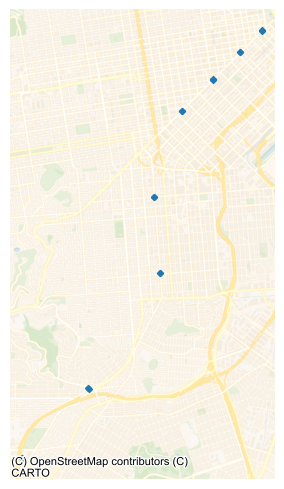

In [341]:
fig, ax = plt.subplots(figsize=(5, 5))
bart_stops.plot(ax=ax, markersize=9, marker="D")
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=bart_stops.crs)
ax.axis("off")
fig.tight_layout();

https://stackoverflow.com/questions/68175234/change-contextily-basemap-size/79653580#79653580

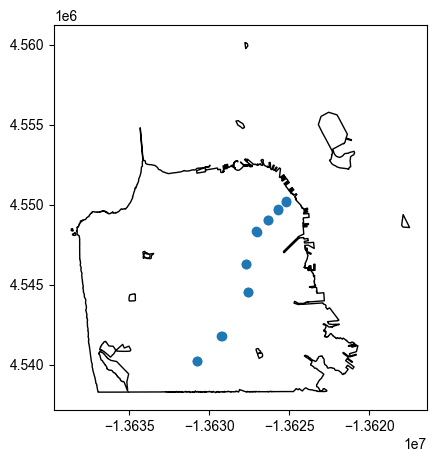

In [342]:
fig, ax = plt.subplots(figsize=(5, 5))
sf_no_water_web_map.plot(ax=ax, facecolor="none")
bart_stops.plot(ax=ax);

In [343]:
sf_bounds = sf_no_water_web_map.bounds.iloc[0]
sf_bounds

minx   -1.363863e+07
miny    4.538246e+06
maxx   -1.361748e+07
maxy    4.560119e+06
Name: 0, dtype: float64

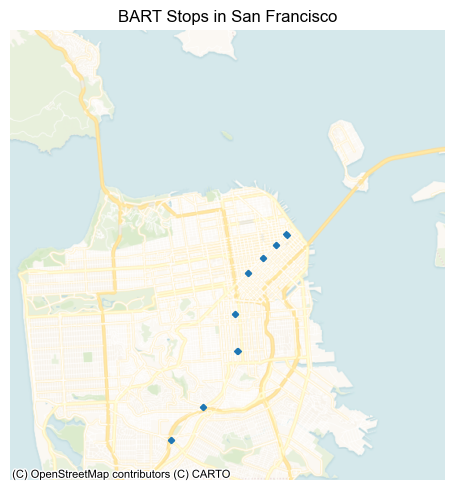

In [344]:
fig, ax = plt.subplots(figsize=(5, 5))
bart_stops.plot(ax=ax, markersize=9, marker="D")
# Use another shape to determine the zoom/map size
assert sf_no_water_web_map.crs == bart_stops.crs
ax.set(xlim = (sf_bounds['minx'], sf_bounds['maxx']),
       ylim = (sf_bounds['miny'], sf_bounds['maxy'])
       )
ax.axis("off")
ax.set(title="BART Stops in San Francisco")
fig.tight_layout()
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=bart_stops.crs)

### Physical Infrastructure Features with `osmnx`

Open Street Maps' features API requires us to pass in a bounding box in the WGS84 projects along with tags that select features and it returns all of the requested features within that bounding box. Here, I pass in the bay area's total bounds in the WGS84 projects, and specify subway rail (this is how Open Street Maps classifies BART).  

The code returns a geodataframe of all of the subway rail in the bay area, stored as line segments with various interesting characteristics (e.g. max speed, whether it's an underground or above ground segment, etc).

In [345]:
sf_bart_web = (
    ox.features
    .features_from_bbox(
        bbox=sf_no_water_web_map.to_crs("EPSG:4326").total_bounds,
        tags={"railway": "subway"})
    .to_crs(PSEUDO_MERCATOR_CRS))

sf_bart_web.head(2)

geometry    name  \
element id                                                                    
way     24141635  LINESTRING (-13630727.47 4540516.258, -1363074...  M-Line   
        24141683  LINESTRING (-13630771.441 4540324.869, -136307...  M-Line   

                 network operator railway electrified frequency gauge layer  \
element id                                                                    
way     24141635    BART      NaN  subway        rail         0  1676    -1   
        24141683    BART      NaN  subway        rail         0  1676   NaN   

                 maxspeed                                          owner  \
element id                                                                 
way     24141635   36 mph  San Francisco Bay Area Rapid Transit District   
        24141683   36 mph  San Francisco Bay Area Rapid Transit District   

                 railway:preferred_direction tunnel voltage cutting level  \
element id                                                                  
way     24141635                     forward    yes    1000     NaN   NaN   
        24141683                     forward    NaN    1000     yes   NaN   

                 note wikipedia bridge service  
element id                                      
way     24141635  NaN       NaN    NaN     NaN  
        24141683  NaN       NaN    NaN     NaN

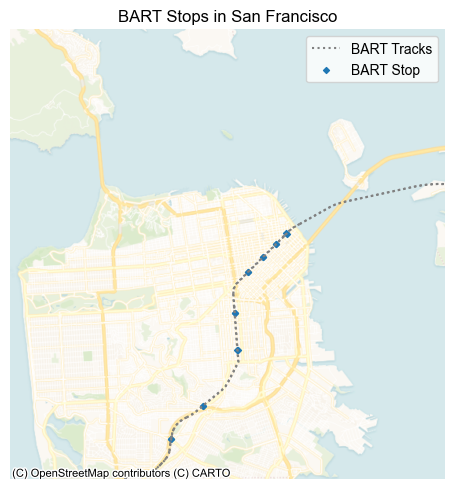

In [346]:
fig, ax = plt.subplots(figsize=(5, 5))
assert sf_no_water_web_map.crs == bart_stops.crs
sf_bounds = sf_no_water_web_map.bounds.iloc[0]
ax.set(xlim = (sf_bounds['minx'], sf_bounds['maxx']),
       ylim = (sf_bounds['miny'], sf_bounds['maxy'])
       )
ax.axis("off")
ax.set(title="BART Stops in San Francisco")
cx.add_basemap(ax, source=cx.providers.CartoDB.VoyagerNoLabels, crs=bart_stops.crs)
sf_bart_web.plot(ax=ax, linestyle=":", color="grey", label="BART Tracks")
bart_stops.plot(ax=ax, markersize=9, marker="D", label="BART Stop")
ax.legend()
fig.tight_layout()